# -----
# FIG S1 in RECCAP SO paper -> trends in simB
# -----
# also store as netcdf to load in script to plot Fig. 8 (see PAPER_RECCAPv2_SO_Fig8_time_series.ipynb)
#
# Plot time series of CO2 fluxes in simB
# drift-corrected
# 
# Contact: cara.nissen@awi.de or cara.nissen@colorado.edu
#
# version: August 2023
#

In [2]:
### modules
import os
import numpy as np
import seawater as sw
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import cm 
from datetime import date, timedelta
import copy
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from annualmean import annualmean
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import date, timedelta
from sklearn.linear_model import LinearRegression
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from scipy import signal # for detrending of time series

/tmp/ipykernel_1712020/2807632428.py:23: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import inset_axes


In [3]:
#-----
# SETTINGS
# define paths to all data
# define where to save plots (if any)
# define years to average over
#-----

# data sets
path1 = '/pscratch/sd/c/cnissen/RECCAPv2/'
path_models = path1+'reccap_submissions/download_20220124/Models/2D_CO2/' 
path_data   = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_atminv = path1+'reccap_submissions/download_20220124/Atmospheric_inversions/'
path_soccom = path1+'reccap_submissions/download_20220124/Surface_CO2/'
path_trend  = path1+'reccap_submissions/download_20220124/Models/Linear_trends/' 

# river flux adjustment
path_river  = path1+'masks_reccap/river_flux_adjustment/'

# path to RECCAP SO mask
path_mask = path1+'masks_reccap/'

#----
# specify years to average over
#----
# NOTE: the script is written to plot the time series from 1985-2018
#    the years are defined here for plot titles and filenames 
year1,year2 = 1985,2018 
eval_time   = np.arange(year1,year2+1) 

#----
# define simulation
#----
sim = 'B'

#----
# define where to save plots
#----
save_to_dir ='/global/cfs/cdirs/m4003/cnissen/Plots/RECCAPv2_SO_Paper/Fig_8/'
if not os.path.exists(save_to_dir):
    print ('Created '+save_to_dir)
    os.makedirs(save_to_dir)
    

In [4]:
#-----
# define data sets to consider
#-----
# NOTE: there is 6 different atm. inversions in the provided file, only load the ones that start in 1990 
# NOTE: AOML has to be the first in the list! there is a few places where the exclusion of AOML is 
# hard-coded as "[1:]"

# variable name of interest
var = '2D_CO2'

models     = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ') 
models2     = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12','ROMS-SO-ETHZ') 
ind_mpi = models.index("MPIOM-HAMOCC")
ind_not_mpi = [i for i, s in enumerate(models) if 'MPIOM-HAMOCC' not in s]
print ('Index of MPI:',ind_mpi)
print ('All inidces except MPI:',ind_not_mpi)
data_assim  = ('BSOSE','ECCO-Darwin')
data_ocim   = ('OCIM-v2014-CTL','OCIM-v2021')
#data_atminv = ['Atm_inv1','Atm_inv2','Atm_inv4']  #'Atm_inv3','Atm_inv5','Atm_inv6' -> start later than 1990
data_atminv = ['Atm_inv1','Atm_inv2','Atm_inv3','Atm_inv4','Atm_inv5','Atm_inv6'] # for 2015-2018, consider all 6
data_prod   = ('AOML_EXTRAT','CMEMS-LSCE-FFNN','CSIRML6','JenaMLS','JMAMLR',\
             'LDEO-HPD','NIES-ML3','OceanSODAETHZ','SOMFFN') 
data_watson = ['UOEX_Wat20']
soccom      = ('SOCCOM_Jena','SOCCOM_SOMFFN')

versionID_models     = ('20211125','v20211122','v20211208','v20220323','v20211119','v20211119',\
                       'v20220125','v20220110','v20220502','v20211125',\
                       'v20210804','v20211215','v20220404','v20220630') 
versionID_data_assim  = ('I134','v20210712')
versionID_data_ocim   = ('v20210607','v20210511')
versionID_data_atminv = ['v20211008']
versionID_data_prod   = ('v20211130','v20210709','v20211117','v20211126','v20211208',\
                       'v20211210','v20220222','v20211207','v20211121')
versionID_data_watson = ['v20211204']

# list of filenames for data products
filename_data_prod = ('fgco2_AOML_EXTRAT_1997-2020_v20211018.nc4',\
                      'fgco2_CMEMS-LSCE-FFNN_1985-2018_v20210709.nc',\
                      'fgco2_CSIRML6_1985-2018_v20211117.nc',\
                      'fgco2_JenaMLS_1985-2018_v20211126.nc',\
                      'fgco2_JMAMLR_1985-2019_v20211208.nc',\
                      'fgco2_LDEO_HPD_1985-2018_v20211210.nc',\
                      'fgco2_NIES-ML3_1980-2020_v20220222.nc',\
                      'fgco2_OceanSODAETHZ_1985-2018_v20211207.nc',\
                      'fgco2_MPI_SOMFFN_1982-2019_v20211121.nc')
filename_data_watson = ['fgco2_UOEX_Wat20_1985-2019_v20211204.nc']

subregions = ('STSS-Atl','STSS-Ind','STSS-Pac',\
              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')   

print ('Models:',len(models),len(versionID_models))
print ('Data products:',len(data_prod),len(filename_data_prod))
print ('Data Watson2020:',len(data_watson),len(versionID_data_watson))
print ('Data assimilating models:',len(data_assim),len(versionID_data_assim))
print ('Data OCIM:',len(data_ocim),len(versionID_data_assim))
print ('Data ATM inversion:',len(data_atminv),len(versionID_data_atminv))


Index of MPI: 7
All inidces except MPI: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13]
Models: 14 14
Data products: 9 9
Data Watson2020: 1 1
Data assimilating models: 2 2
Data OCIM: 2 2
Data ATM inversion: 6 1


In [5]:
#----
# FUNCTIONS
#----

# transform longitude (e.g., go from -179.5:179.5 to 0.5:359.5)
def transform_lon_coord(data):
    # change lon coordinate in 2D array from 0-360 to -180:180
    # for 2D arrays: assume lon coordinate to be the 2nd dimension  
    # for 3D arrays: assume lon coordinate to be the 3rd dimension  
    if len(data.shape)==2:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180] = data[:,180:]
        data_transformed[:,180:]  = data[:,0:180] 
    elif len(data.shape)==3:
        data_transformed          = np.empty_like(data)
        try:
            data_transformed[:,:,0:180] = data[:,:,180:]
            data_transformed[:,:,180:]  = data[:,:,0:180]
        except:
            data_transformed[:,0:180,:] = data[:,180:,:]
            data_transformed[:,180:,:]  = data[:,0:180,:] 
    elif len(data.shape)==4:
        data_transformed          = np.empty_like(data)
        data_transformed[:,0:180,:,:] = data[:,180:,:,:]
        data_transformed[:,180:,:,:]  = data[:,0:180,:,:] 
    elif len(data.shape)==1:
        data_transformed          = np.empty_like(data)
        data_transformed[0:180] = data[180:]
        data_transformed[180:]  = data[0:180]
    return data_transformed


In [6]:
#------
# load RECCAP mask for SO
# make sure region mask matches the submitted products in terms of longitude!
#------

# SO RECCAP regions
#reccap_mask_SO   = Dataset(path_mask+'RECCAP2_region_masks_all_v20221025.nc')
#regions          = reccap_mask_SO_2.variables['southern'][:,:] #"1.SO STSS, 2.SO SPSS, 3.SO ICE"
#lon_regions      = reccap_mask_SO_2.variables['lon'][:]
#print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)
#print(np.min(regions_2),np.max(regions_2))

# SO RECCAP regions
reccap_mask_SO = Dataset(path_mask+'reccap_regions_SOsubs.nc')
regions        = reccap_mask_SO.variables['SO_basins_biomes'][:,:]
lon_regions    = reccap_mask_SO.variables['lon'][:]
print(np.min(lon_regions),np.max(lon_regions)) # lon should be from 0-360 (if it is from -180:180, use transform_lon_coord)

# lon in file is -180:180 -> want 0-360, so transform here
regions = transform_lon_coord(regions)
print(np.min(regions),np.max(regions))


-179.5 179.5
0.0 8.0


In [7]:
#-----
# load data
#-----

years_in_file = np.arange(1980,2018+1)
        
#-----
# models
#-----
flux_models = np.nan*np.ones([180,360,len(eval_time),len(models)])
for ii in range(0,len(models)):
    print ('Load '+models[ii])
    ff = Dataset(path_models+models[ii]+'_'+var+'_'+versionID_models[ii]+'/'+\
                    'fgco2_'+models[ii]+'_'+sim+'_1_gr_1980-2018_'+versionID_models[ii]+'.nc')
    data = np.squeeze(ff.variables['fgco2'][:,:,:])
    data = annualmean(data)
    if models[ii] in ['CCSM-WHOI']: # kick out years 1958-1979
        data = -1*data[22:,:,:] # flip sign
    if models[ii] in ['MPIOM-HAMOCC']: # kick out 2019
        data = data[:-1,:,:]
    print (data.shape)
        
    try: 
        data[data.mask==True]=np.nan
    except: 
        pass
    # EC-Earth has zeros in fields!
    try: 
        data[data==0]=np.nan
    except: 
        pass
        
    # find position into which to write annual means (depends on years provided in submission)
    if models[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']: # these ones stop in 2017
        start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
        end_ind   = np.argmin(np.abs(eval_time-2017)) 
    else:
        start_ind = np.where(np.asarray(years_in_file)==year1)[0][0]
        end_ind   = np.where(np.asarray(years_in_file)==year2)[0][0]
        
    data = np.transpose(data,[1,2,0])
    if models[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']:
        flux_models[:,:,:end_ind+1,ii] = data[:,:,start_ind:]
    else: 
        flux_models[:,:,:,ii] = data[:,:,start_ind:end_ind+1] #np.nanmean(data,axis=0)
    ff.close()
    del data


Load CCSM-WHOI
(38, 180, 360)
Load CESM-ETHZ
(39, 180, 360)
Load CNRM-ESM2-1
(39, 180, 360)
Load EC-Earth3
(39, 180, 360)
Load FESOM_REcoM_HR


/global/u2/c/cnissen/scripts_reccap/annualmean.py:43: RuntimeWarning: Mean of empty slice
  var_annualmean[t,:,:] = np.nanmean(datamB, axis=0)


(39, 180, 360)
Load FESOM_REcoM_LR
(39, 180, 360)
Load MOM6-Princeton
(39, 180, 360)
Load MPIOM-HAMOCC
(39, 180, 360)
Load MRI-ESM2-1
(39, 180, 360)
Load NorESM-OC1.2
(39, 180, 360)
Load ORCA025-GEOMAR
(39, 180, 360)
Load ORCA1-LIM3-PISCES
(39, 180, 360)
Load PlankTOM12
(39, 180, 360)
Load ROMS-SouthernOcean-ETHZ
(39, 180, 360)


In [8]:
#------
# print some numbers (to spot any obvious unit problems)
#------

for ii in range(0,len(models)):
    print (models[ii]+': '+str(np.nanmin(flux_models[:,:,:,ii]))+' '+str(np.nanmax(flux_models[:,:,:,ii])))


CCSM-WHOI: -2.3674363092140993e-07 1.644995251126602e-07
CESM-ETHZ: -1.58580931497454e-07 1.198076091668554e-07
CNRM-ESM2-1: -1.9778416279373244e-07 2.2020151785125276e-07
EC-Earth3: -3.500973377867922e-07 1.6001040137325617e-07
FESOM_REcoM_HR: -1.0501427996895888e-06 2.2524343348449806e-07
FESOM_REcoM_LR: -5.158950544230697e-07 2.3708359034050097e-07
MOM6-Princeton: -5.291133494281837e-07 3.4244327088726055e-07
MPIOM-HAMOCC: -1.4469600273514516e-07 1.8827707037871733e-07
MRI-ESM2-1: -5.326621135282039e-07 1.672179337219859e-07
NorESM-OC1.2: -2.396884326572035e-07 1.7760824277957e-07
ORCA025-GEOMAR: -5.100986278706034e-07 2.448828950144617e-07
ORCA1-LIM3-PISCES: -4.5353158384386916e-07 2.0009440504509257e-07
PlankTOM12: -3.6768275890608493e-07 1.144406382991292e-07
ROMS-SouthernOcean-ETHZ: -1.6997863383494405e-07 3.257675587065023e-07


In [9]:
#------
# get surface area of all the biomes
#------
# calculate area with sw.dist

def get_areas_biomes(area,regions,subregions):
    # calculate area-weighted averages of a given quantity in data according to biomes defined
    # after Fay & McKinley (2014), use RECCAP mask loaded further up
    # provide "area" (with lon from 0:360)
    
    # only consider area for SO RECCAP mask
    area[regions.mask==True]=0
    print ('Total Southern Ocean ocean surface area '+str(np.nansum(area))+' m2')
    
    data_avg = np.zeros(13) # 9 regions in SO, + 3 for combined sectors, +1 for whole SO
    for i in range(0,13):
        reg2  = regions.ravel()
        area2 = area.ravel()
        if subregions[i] in ['STSS-Atl']:
            ind_region = np.where(reg2==0)[0]
        elif subregions[i] in ['STSS-Ind']:
            ind_region = np.where(reg2==3)[0]
        elif subregions[i] in ['STSS-Pac']:
            ind_region = np.where(reg2==6)[0]
        elif subregions[i] in ['SPSS-Atl']:
            ind_region = np.where(reg2==1)[0]
        elif subregions[i] in ['SPSS-Ind']:
            ind_region = np.where(reg2==4)[0]
        elif subregions[i] in ['SPSS-Pac']:
            ind_region = np.where(reg2==7)[0]
        elif subregions[i] in ['ICE-Atl']:
            ind_region = np.where(reg2==2)[0]
        elif subregions[i] in ['ICE-Ind']:
            ind_region = np.where(reg2==5)[0]
        elif subregions[i] in ['ICE-Pac']:
            ind_region = np.where(reg2==8)[0]
        elif subregions[i] in ['STSS']:
            ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
        elif subregions[i] in ['SPSS']:
            ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
        elif subregions[i] in ['ICE']:
            ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
        elif subregions[i] in ['all']:
            ind_region = np.where(reg2>=0)[0]
        data_avg[i] = np.nansum(area2[ind_region]) #np.nansum(data2[ind_region]*area2[ind_region]/total_area)
        del reg2, area2,ind_region
    return data_avg

# define for filtering, but don't use for area calculation
lon = np.arange(0.5,359.5+1,1)
lat = np.arange(-89.5,89.5+1,1)

# need the box boundaries for area calculation
xi = np.arange(0,360+1,1)
yi = np.arange(-90,90+1,1) 

area = np.zeros((len(xi)-1,len(yi)-1))
#calculate area
for i in range(0,len(xi)-1): #laenge pruefen!
    if i==np.round(len(xi)/2): 
        print ('50% done')
    for j in range(0,len(yi)-1): 
        dist1 = sw.dist([yi[j],yi[j+1]],[xi[i],xi[i]])
        dist2 = sw.dist([yi[j],yi[j]],[xi[i],xi[i+1]])
        area[i][j] = float(dist1[0]) * float(dist2[0]) *1000 *1000 #m2
area = area.transpose()
print ('Global area:',np.sum(area),'m2') 
area_global = np.copy(area)

area_biomes = get_areas_biomes(area,regions,subregions)

#print (area_biomes)
print('TEST: the following three should be identical')
print (np.sum(area_biomes[0:9])) # 9 subregions
print (np.sum(area_biomes[9:12])) # 3 subregions
print (np.sum(area_biomes[12])) # 1 subregion 


50% done
Global area: 509364377985322.94 m2
Total Southern Ocean ocean surface area 77409028462219.4 m2
TEST: the following three should be identical
77409028462219.4
77409028462219.42
77409028462219.42


In [10]:
#-----
# get subareas avg
#-----
# NOTE: for each product/model, get areas of biomes separately
# the areas are not the same for the different prodcuts

def get_subarea_avg(flux_models,regions,area,eval_time,models_ABCD,subregions):
    flux_subareas  = np.nan*np.ones([len(eval_time),len(models_ABCD),len(subregions)]) 
    biome_areas    = np.nan*np.ones([len(models_ABCD),len(subregions)]) 
    for pp in range(0,len(models_ABCD)):
        counter=0 # only for printing of total area
        print ('Process '+models_ABCD[pp])
        for i in range(0,len(subregions)):
            for yy in range(0,len(eval_time)):
                data1 = flux_models[:,:,yy,pp]
                reg2  = regions.ravel()  # SO RECCAP mask
                area2 = area.ravel() # surface area
                data2 = data1.ravel()
                if subregions[i] in ['STSS-Atl']:
                    ind_region = np.where(reg2==0)[0]
                elif subregions[i] in ['STSS-Ind']:
                    ind_region = np.where(reg2==3)[0]
                elif subregions[i] in ['STSS-Pac']:
                    ind_region = np.where(reg2==6)[0]
                elif subregions[i] in ['SPSS-Atl']:
                    ind_region = np.where(reg2==1)[0]
                elif subregions[i] in ['SPSS-Ind']:
                    ind_region = np.where(reg2==4)[0]
                elif subregions[i] in ['SPSS-Pac']:
                    ind_region = np.where(reg2==7)[0]
                elif subregions[i] in ['ICE-Atl']:
                    ind_region = np.where(reg2==2)[0]
                elif subregions[i] in ['ICE-Ind']:
                    ind_region = np.where(reg2==5)[0]
                elif subregions[i] in ['ICE-Pac']:
                    ind_region = np.where(reg2==8)[0]
                elif subregions[i] in ['STSS']:
                    ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
                elif subregions[i] in ['SPSS']:
                    ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
                elif subregions[i] in ['ICE']:
                    ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
                elif subregions[i] in ['all']:
                    ind_region = np.where(reg2>=0)[0]
                    
                ind_not_nan_data = np.where(~np.isnan(data2[ind_region]))[0] # only consider data points that are filled
                total_area = np.sum(area2[ind_region][ind_not_nan_data])
                #total_area = np.sum(area2[ind_region])
                if np.nansum(data1)!=0: # only for years which are filled
                    if (subregions[i] in ['all']) & (counter==0):
                        print (total_area)
                        counter = 1
                    biome_areas[pp,i] = total_area 
                    flux_subareas[yy,pp,i] = np.nansum(data2[ind_region]*area2[ind_region]/total_area)
                del data1,reg2,area2,data2,ind_region,total_area
    return flux_subareas,biome_areas
    

In [11]:
#------
# get subarea mean of models, data product, data assimilation products
#------

# calculate subarea averages
#subregions = ('STSS_Atl','SPSS_Atl','ICE_Atl','STSS_Ind','SPSS_Ind',\
#              'ICE_Ind','STSS_Pac','SPSS_Pac','ICE_Pac','STSS','SPSS','ICE')#,'all')
# 13 regions: 9 regions in SO, + 3 for combined sectors, +1 for whole SO

print ('-----')
print ('models')
print ('-----')
flux_models_subareas,biome_area_models = get_subarea_avg(flux_models,regions,area,\
                                                eval_time,models,subregions)
          

-----
models
-----
Process CCSM-WHOI
74492275264407.1
Process CESM-ETHZ
76149904481959.67
Process CNRM-ESM2-1
77371852756049.22
Process EC-Earth3
77367548050317.14
Process FESOM_REcoM_HR
77075005194060.84
Process FESOM_REcoM_LR
77075005194060.84
Process MOM6-Princeton
77075005194060.84
Process MPIOM-HAMOCC
76003285884316.31
Process MRI-ESM2-1
77325948214566.8
Process NorESM-OC1.2
77374505093557.94
Process ORCA025-GEOMAR
77289199561810.75
Process ORCA1-LIM3-PISCES
77402636845977.3
Process PlankTOM12
76670454088793.06
Process ROMS-SouthernOcean-ETHZ
76894536194319.66


In [12]:
#---
# print some more numbers
#---

ss = -1

print ('######')
print ('Subregion '+subregions[ss]+':')
print ('######')

for ii in range(0,len(models)):
    if models[ii] in ['OCIM-v2014-CTL','CCSM-WHOI']: # year 2018 not available!, print year 2017!
        print (models[ii]+': '+str(flux_models_subareas[-2,ii,ss])) # last year, whole SO 
    else:
        print (models[ii]+': '+str(flux_models_subareas[-1,ii,ss])) # last year, whole SO 
           

######
Subregion all:
######
CCSM-WHOI: 1.0067674412879318e-09
CESM-ETHZ: 3.599700842191882e-09
CNRM-ESM2-1: -6.8262879916387965e-09
EC-Earth3: -1.45502460992573e-08
FESOM_REcoM_HR: 1.7924769495533394e-08
FESOM_REcoM_LR: 1.3215745226546954e-08
MOM6-Princeton: 1.051614670779784e-08
MPIOM-HAMOCC: 1.1172614086973412e-08
MRI-ESM2-1: -6.7260390264257705e-09
NorESM-OC1.2: 9.949784352151041e-09
ORCA025-GEOMAR: 1.0028842782879985e-08
ORCA1-LIM3-PISCES: 4.002762721875174e-09
PlankTOM12: -4.373745741830237e-09
ROMS-SouthernOcean-ETHZ: 4.054968374855639e-09


In [13]:
#-----
# get multi-model and multi-data mean
#-----

multi_model_mean      = np.nanmean(flux_models_subareas,axis=1)
print ('CCSM-WHOI (all):',flux_models_subareas[:,0,-1])
    
# get mean area for each product class
area_mean_models        = np.mean(biome_area_models[:,:],axis=0) 
print ('area_mean_models (all):',area_mean_models[-1])


CCSM-WHOI (all): [5.15226464e-10 4.50380304e-10 4.44575667e-10 3.82491615e-10
 4.36053695e-10 5.26462634e-10 5.00182996e-10 5.04876654e-10
 5.78129494e-10 7.82261096e-10 7.22807787e-10 7.64899660e-10
 7.83807944e-10 9.08908659e-10 6.96094347e-10 8.56072543e-10
 7.28353813e-10 1.00798538e-09 6.37202609e-10 8.10291839e-10
 7.66330399e-10 7.46118405e-10 8.49576475e-10 9.69877914e-10
 8.77356267e-10 8.50216684e-10 1.10150239e-09 9.43803570e-10
 1.17678036e-09 1.08789159e-09 1.05226430e-09 9.25732745e-10
 1.00676744e-09            nan]
area_mean_models (all): 76826225858446.95


In [14]:
#----
# load river file, apply to model fields
#----

river_adjustment = True
if river_adjustment: 
    river_adj_names = ('Lacroix2020')
    ff = Dataset(path_river+'fgco2_lacroix-river_v20211223.nc')
    river = ff.variables['fgco2'][:] # lon is 0-360, needs to be transformed for plotting
    ff.close()
    print (river.shape)

subregions = ('STSS-Atl','STSS-Ind','STSS-Pac',\
              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')

# 13 regions: 9 regions in SO, + 3 for combined sectors, +1 for whole SO

if river_adjustment: 
    #------
    # models
    #------
    river_subareas   = np.nan*np.ones([len(subregions)]) 
    biome_area_river      = np.nan*np.ones([len(subregions)]) 
    print ('Process river file ')
    for i in range(0,len(subregions)):
        data1 = np.copy(river)
        reg2  = regions.ravel()  # SO RECCAP mask
        area2 = area.ravel() # surface area
        data2 = data1.ravel()
            
        if subregions[i] in ['STSS-Atl']:
            ind_region = np.where(reg2==0)[0]
        elif subregions[i] in ['STSS-Ind']:
            ind_region = np.where(reg2==3)[0]
        elif subregions[i] in ['STSS-Pac']:
            ind_region = np.where(reg2==6)[0]
        elif subregions[i] in ['SPSS-Atl']:
            ind_region = np.where(reg2==1)[0]
        elif subregions[i] in ['SPSS-Ind']:
            ind_region = np.where(reg2==4)[0]
        elif subregions[i] in ['SPSS-Pac']:
            ind_region = np.where(reg2==7)[0]
        elif subregions[i] in ['ICE-Atl']:
            ind_region = np.where(reg2==2)[0]
        elif subregions[i] in ['ICE-Ind']:
            ind_region = np.where(reg2==5)[0]
        elif subregions[i] in ['ICE-Pac']:
            ind_region = np.where(reg2==8)[0]
        elif subregions[i] in ['STSS']:
            ind_region = np.where((reg2==0) | (reg2==3) | (reg2==6))[0]
        elif subregions[i] in ['SPSS']:
            ind_region = np.where((reg2==1) | (reg2==4) | (reg2==7))[0]
        elif subregions[i] in ['ICE']:
            ind_region =np.where((reg2==2) | (reg2==5) | (reg2==8))[0]
        elif subregions[i] in ['all']:
            ind_region = np.where(reg2>=0)[0]
        ind_not_nan_data = np.where(~np.isnan(data2[ind_region]))[0] # only consider data points that are filled
        total_area = np.sum(area2[ind_region][ind_not_nan_data])
        if subregions[i] in ['all']:
            print (total_area)
        biome_area_river[i] = total_area 
        #total_area = np.sum(area2[ind_region])
        if np.nansum(data1)!=0: # only for years which are filled
            river_subareas[i] = np.nansum(data2[ind_region]*area2[ind_region]/total_area)
        del data1,reg2,area2,data2,ind_region,total_area
        
#-------
# save field to apply to model output
#-------

if river_adjustment:
    add_to_models = np.copy(river_subareas)
else:
    add_to_models = np.zeros_like(river_subareas) # add a field of zeros
print ('River fluxes to add for subregion all:',add_to_models[-1])

    
#----
# check for river fluxes
#----
if river_adjustment:
    print ('')
    print ('River flux adjustment (pos=outgassing):')
    factor_river = 365.25*86400.*12.011/1e15 # don't use "-1" here; global number should positive = outgassing due to rivers
    for ss in range(0,len(subregions)):
        print (subregions[ss]+': '+str(factor_river*river_subareas[ss]*biome_area_river[ss])+' Pg C yr-1')
    # check: add up 3 subregions
    print ('based on STSS/SPSS/ICE: '+str(np.sum(factor_river*river_subareas[9:12]*biome_area_river[9:12]))+' Pg C yr-1')

    print ('Global ocean area: '+str(np.sum(area_global))+' m2')
    print ('Global river flux: '+str(np.nansum(factor_river*np.multiply(river,area_global)))+' Pg C yr-1')
    print ('SO/Global: '+str(100*factor_river*river_subareas[-1]*biome_area_river[-1]/np.nansum(factor_river*np.multiply(river,area_global)))+'%')
    print ('')
    #print river



(180, 360)
Process river file 
76118473462222.84
River fluxes to add for subregion all: 1.3662420531327198e-09

River flux adjustment (pos=outgassing):
STSS-Atl: -0.01546799211558836 Pg C yr-1
STSS-Ind: 0.0026367052644284345 Pg C yr-1
STSS-Pac: -0.0013755711900539146 Pg C yr-1
SPSS-Atl: -0.008262337193420477 Pg C yr-1
SPSS-Ind: 0.045257119271516585 Pg C yr-1
SPSS-Pac: 0.016270984555087874 Pg C yr-1
ICE-Atl: -0.0035661499261086895 Pg C yr-1
ICE-Ind: 0.0054982502435766975 Pg C yr-1
ICE-Pac: -0.0015724400214355222 Pg C yr-1
STSS: -0.014206858041213835 Pg C yr-1
SPSS: 0.05326576663318398 Pg C yr-1
ICE: 0.00035966029603248497 Pg C yr-1
all: 0.03941856888800264 Pg C yr-1
based on STSS/SPSS/ICE: 0.03941856888800263 Pg C yr-1
Global ocean area: 509364377985322.94 m2
Global river flux: 0.6158395517429716 Pg C yr-1
SO/Global: 6.400785525456877%



In [15]:
#-----
# PLOTTING
#-----

In [16]:
#------
# FIG for paper: combine panels
#------

In [17]:

def subroutine_plotting_time_series_1region_colors(ax,biome_area_models,models_all,\
                                                   add_to_models,biome_area_river,\
                                                            models,eval_time,factor,unit,\
                                       subregions,panel_label,counter,\
                                            yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,leg_prop):
    
                            
    lw_mean          = 2.5
    lw_all           = 1
    alpha_value      = 0.3
    alpha_std=0.3
    fs_text = 9
    
    line_type_list = ('-','-','-','-','-','-','-','-','-','-',':',':',':',':',':',':',':')
    
    #from matplotlib.colors import ListedColormap
    
    color_list = [(51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                  (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                  (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                   (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.),\
                   (170./255.,68./255.,153./255.),(170./255.,170./255.,170./255.),\
                  
                  (51./255.,34./255.,136./255.),(136./255.,204./255.,238./255.),\
                  (68./255.,170./255.,153./255.),(17./255.,119./255.,51./255.),\
                  (153./255.,153./255.,51./255.),(221./255.,204./255.,119./255.),\
                   (204./255.,102./255.,119./255.),(136./255.,34./255.,85./255.),\
                   (170./255.,68./255.,153./255.),(170./255.,170./255.,170./255.)]
    #color_list = ListedColormap(color_list)
    
    factor_river = 365.25*86400.*12.011/1e15 # for river fluxes, no need to multiply by "-1" -> pos=outgassing already!

    #-----
    # MODELS
    #-----
    add_rivers = factor_river*biome_area_river*add_to_models
    add_each_year = add_rivers*np.ones(len(eval_time))
    
    # create array of area: models x time (area constant in time)
    area_2d = np.transpose(np.tile(biome_area_models[:],[len(eval_time),1])) # should be models x time
    
    model_data_mean = np.nanmean(area_2d*factor*models_all[:,:],axis=0)+add_each_year
    model_data_std = np.nanstd(area_2d*factor*models_all[:,:],axis=0)
    #print model_data_std
    #a2a = area_mean_models*factor*model_mean[:]+model_data_std
    #a2b = area_mean_models*factor*model_mean[:]-model_data_std
    a2a = model_data_mean+model_data_std
    a2b = model_data_mean-model_data_std
    for dd in range(0,models_all.shape[0]):
        #print 'Avg for '+models[dd]+': '+str(np.nanmean(biome_area_models[dd]*factor*models_all[dd,:]+add_each_year))
        ax.plot(range(0,len(eval_time)),biome_area_models[dd]*factor*models_all[dd,:]+add_each_year,\
                    color=color_list[dd], linewidth=2.0,linestyle=line_type_list[dd], alpha=0.8) #ax=ax, hue=dim
    
    ax.set_xlim((0.0,len(eval_time)-1))
    ax.set_ylim((ylim1,ylim2))
    
    if counter==0: # don't plot for STSS
        ax.hlines(0,0,len(eval_time),color='k', linestyle='--', linewidth=0.5, zorder=0)

    if yticks_on: 
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)
        ax.set_ylabel(unit,fontsize=fs_text+2)
    else: 
        ax.set_yticks([])
        ax.set_yticklabels([])
        
    ax.set_xticks(np.arange(0,len(eval_time),5))
    ax.set_xticklabels(eval_time[0::5])

    for label in ax.yaxis.get_majorticklabels():
            label.set_size(fs_text)
    for label in ax.xaxis.get_majorticklabels():
            label.set_size(fs_text)

    #if counter==0:
    #ax.legend(loc='right',bbox_to_anchor=leg_pos, \
    #                      ncol=leg_col,fancybox=False,frameon=False,shadow=False,prop=leg_prop) 
    ax.annotate(panel_label,xy=(0.02,0.94), xycoords='axes fraction',
                         fontsize=fs_text+1,fontweight='bold')
    ax.annotate(subregions,xy=(0.1,0.94), xycoords='axes fraction',fontsize=fs_text+1)



all
STSS
SPSS
ICE
fig_suppl_time_series_CO2_flux_simB_avg_1985_2018_all_models__wRiver_Adjustment


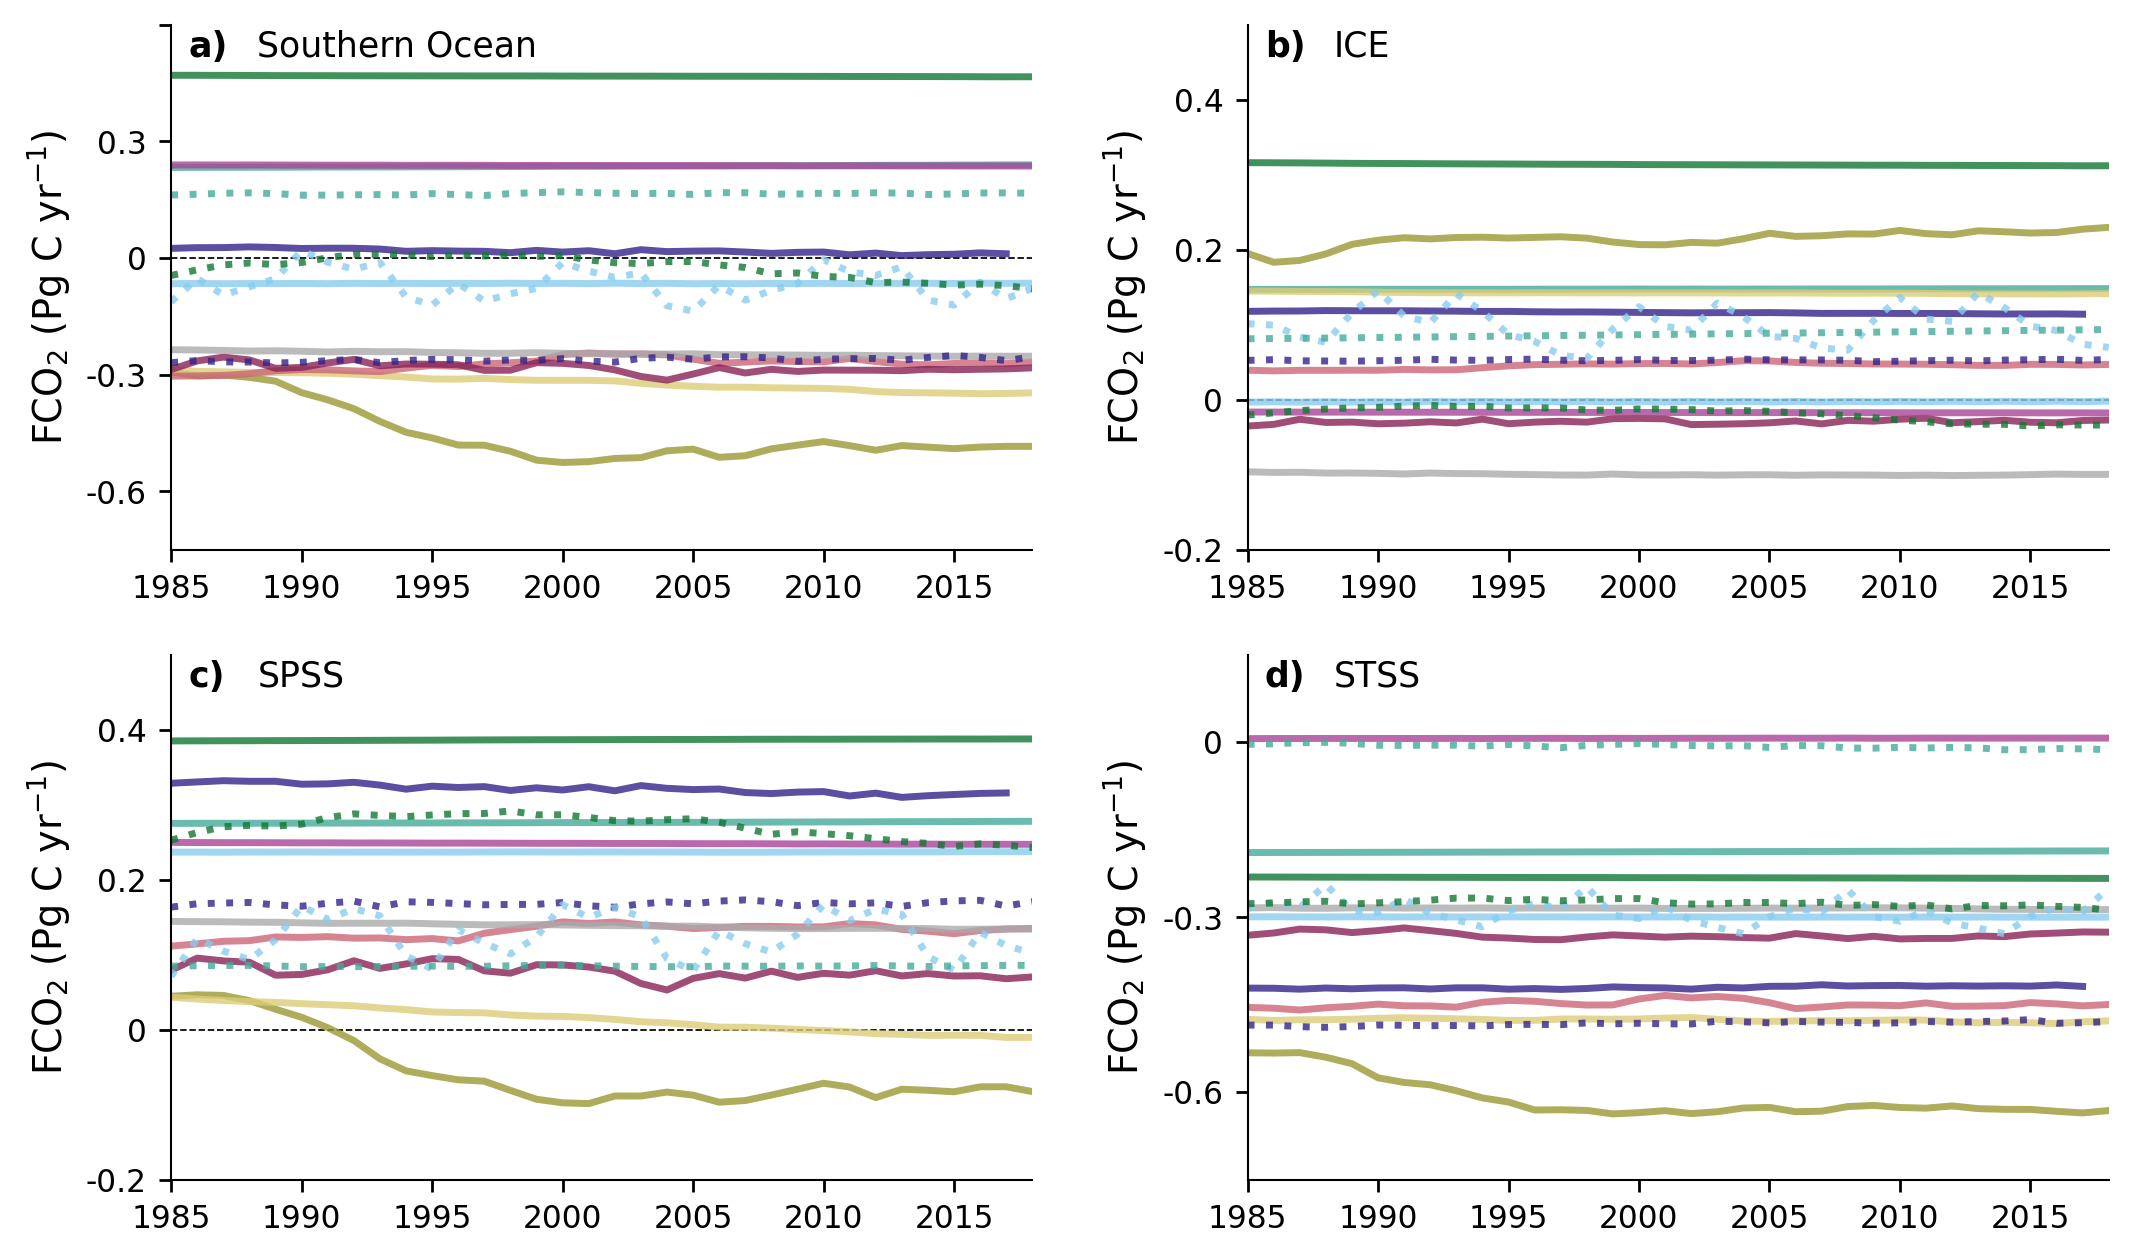

In [18]:
#---
# plot
#---

dpicnt = 250

matplotlib.rcParams['axes.linewidth'] = 0.6 #set the value globally
plt.rc('axes.spines', **{'bottom':True, 'left':True, 'right':False, 'top':False})
    
panel_labels = ['a)','d)','c)','b)']

unit    = 'FCO$_{2}$ (Pg C yr$^{-1}$)'
factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1


fig, axs = plt.subplots(2,2,figsize=(10,6), dpi=dpicnt,\
                            gridspec_kw={'width_ratios': [1,1],\
                                         'height_ratios': [1,1]})
plt.subplots_adjust(wspace=0.25)
plt.subplots_adjust(hspace=0.2)

ax1 = plt.subplot2grid((2,2), (0,0))#, colspan=6) # all
ax2 = plt.subplot2grid((2,2), (0,1))#, colspan=6) # STSS
ax3 = plt.subplot2grid((2,2), (1,0))#, colspan=6) # SPSS
ax4 = plt.subplot2grid((2,2), (1,1))#, colspan=6) # ICE


# transpose arrays for function:
# expected input: data: models x regions x time, data_mean: regions x time; swap dimensions in arrays
flux_models_subareas_plot     = np.transpose(flux_models_subareas,[1,2,0])
multi_model_mean_plot      = np.transpose(multi_model_mean,[1,0])

leg_pos = (0.72, 0.135) #(1.01, 0.73)
leg_col = 2
prop={'size': 6}
    
#-----
# all
#-----
ax=ax1
rr = subregions.index("all") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 1
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-0.75,0.6
yticks = [-0.6,-0.3,0,0.3,0.6]
yticklabels =[-0.6,-0.3,0,0.3,'']
yticks_on=True
#subroutine_plotting_time_series_1region_colors(ax,biome_area_models,models_all,\
#                                                   add_to_models,biome_area_river,\
#                                                            models,eval_time,factor,unit,\
#                                       subregions,panel_label,counter,\
#                                            yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,leg_prop)
subroutine_plotting_time_series_1region_colors(ax,biome_area_models[:,rr],\
                                        flux_models_subareas_plot[:,rr,:],\
                                                add_to_models[rr],biome_area_river[rr],\
                                                models,eval_time,factor2,unit,\
                                       'Southern Ocean',panel_label,counter,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)

#-----
# STSS
#-----
ax=ax4
#ax.set_axis_off()
rr = subregions.index("STSS") # region index
print (subregions[rr])
counter = 1 # if set to 1, print legend
panel_number = 2
panel_label = panel_labels[panel_number-1]
ylim1,ylim2=-0.75,0.15 #-0.0
yticks = [-0.6,-0.3,0]
yticklabels =[-0.6,-0.3,0]
yticks_on=True
subroutine_plotting_time_series_1region_colors(ax,biome_area_models[:,rr],\
                                        flux_models_subareas_plot[:,rr,:],\
                                                add_to_models[rr],biome_area_river[rr],\
                                                models,eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)

# same yticks etc for two of the subregions: 
ylim1,ylim2=-0.2,0.5
yticks = [-0.2,0,0.2,0.4]
yticklabels =[-0.2,0,0.2,0.4]
    
#-----
# SPSS
#-----
ax=ax3
#ax.set_axis_off()
rr = subregions.index("SPSS") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 3
panel_label = panel_labels[panel_number-1]
yticks_on=True
subroutine_plotting_time_series_1region_colors(ax,biome_area_models[:,rr],\
                                        flux_models_subareas_plot[:,rr,:],\
                                                add_to_models[rr],biome_area_river[rr],\
                                                models,eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)


#-----
# ICE
#-----
ax=ax2
#ax.set_axis_off()
rr = subregions.index("ICE") # region index
print (subregions[rr])
counter = 0 # if set to 1, print legend
panel_number = 4
panel_label = panel_labels[panel_number-1]
yticks_on=True
subroutine_plotting_time_series_1region_colors(ax,biome_area_models[:,rr],\
                                        flux_models_subareas_plot[:,rr,:],\
                                                add_to_models[rr],biome_area_river[rr],\
                                                models,eval_time,factor2,unit,\
                                       subregions[rr],panel_label,counter,\
                                        yticks_on,ylim1,ylim2,yticks,yticklabels,leg_pos,leg_col,prop)
    
if river_adjustment:
    river_name = '_wRiver_Adjustment'
else:
    river_name = ''
    
filename1 = 'fig_suppl_time_series_CO2_flux_simB_avg_'+str(year1)+'_'+str(year2)+\
    '_all_models_'+river_name
print (filename1)
    
plt.savefig(save_to_dir+filename1+'.png',dpi = dpicnt, bbox_inches='tight',format='png')
plt.savefig(save_to_dir+filename1+'.pdf',dpi = dpicnt, bbox_inches='tight',format='pdf')
plt.show()





In [19]:

#-----
# get trend for each model
#-----

def get_slope_each_product(biome_area_models,models_all,add_to_models,biome_area_river,\
                                                            models,eval_time,factor,year_start,year_end):
    
    #-----
    # MODELS
    #-----
    factor_river = 1.0
    add_rivers = factor_river*biome_area_river*add_to_models
    add_each_year = add_rivers*np.ones(len(eval_time))
    
    # create array of area: models x time (area constant in time)
    area_2d = np.transpose(np.tile(biome_area_models[:],[len(eval_time),1])) # should be models x time
    
    model_data_mean = np.nanmean(area_2d*factor*models_all[:,:],axis=0)+add_each_year
    model_data_std = np.nanstd(area_2d*factor*models_all[:,:],axis=0)
    #print model_data_std
    #a2a = area_mean_models*factor*model_mean[:]+model_data_std
    #a2b = area_mean_models*factor*model_mean[:]-model_data_std
    a2a = model_data_mean+model_data_std
    a2b = model_data_mean-model_data_std

    #---
    # plot linear fits (from year XX onwards)
    #---
    #year_start = 1985
    ##ind2000 = np.where(eval_time==year_start)[0][0]
    #x = np.array(np.arange(0,len(eval_time[ind2000:]))).reshape((-1, 1))
    
    ind2000 = np.where((eval_time>=year_start) & (eval_time<=year_end))[0]
    #print (eval_time[ind2000])
    x = np.array(np.arange(0,len(eval_time[ind2000]))).reshape((-1, 1))
    
    # MULTI-MODEL MEAN
    a1 = model_data_mean[ind2000] 
    ind_noNaN = np.where(~np.isnan(a1))[0]
    a1 = a1[ind_noNaN]
    x1 = x[ind_noNaN]
    model = LinearRegression()
    model.fit(x1, a1)
    model = LinearRegression().fit(x1, a1)
    slope_mmm = 10*model.coef_[0]
    #print 'slope models (per decade): ',10*model.coef_[0]
    
    # MODELS
    slope_models = np.zeros(len(models))
    for ii in range(0,len(models)):
        ddd=area_2d[ii,:]*factor*models_all[ii,:]+add_each_year
        a1 = ddd[ind2000]
        ind_noNaN = np.where(~np.isnan(a1))[0]
        a1 = a1[ind_noNaN]
        model = LinearRegression()
        if models[ii] in ['CCSM-WHOI']:
            if year_end==2018:
                x1 = np.array(np.arange(0,len(eval_time[ind2000])-1)).reshape((-1, 1))
                model.fit(x1, a1)
                model = LinearRegression().fit(x1, a1) 
            else:
                x = np.array(np.arange(0,len(eval_time[ind2000]))).reshape((-1, 1))
                x1 = x[ind_noNaN]
                model.fit(x1, a1)
                model = LinearRegression().fit(x1, a1)
        else:
            x = np.array(np.arange(0,len(eval_time[ind2000]))).reshape((-1, 1))
            x1 = x[ind_noNaN]
            model.fit(x1, a1)
            model = LinearRegression().fit(x1, a1)
            
      #  if models[ii] in ['CCSM-WHOI']:
      #      x1 = np.array(np.arange(0,len(eval_time[ind2000:-1]))).reshape((-1, 1))
      #      #print x1.shape
      #      #print a1.shape
      #      model.fit(x1, a1)
      #      model = LinearRegression().fit(x1, a1) 
      #  else:
      #      x = np.array(np.arange(0,len(eval_time[ind2000:]))).reshape((-1, 1))
      #      x1 = x[ind_noNaN]
      #      model.fit(x1, a1)
      #      model = LinearRegression().fit(x1, a1)
        #model = LinearRegression().fit(x, a1)
        slope_models[ii]=10*model.coef_[0]
        #print (models[ii]+': ',str(10*model.coef_[0])+' Pg C yr-1 dec-1')
        # Make predictions using the testing set
        #pred_data = model.predict(np.array(np.arange(0,len(eval_time[ind2000:]))).reshape((-1, 1)))
        #ax.plot(np.arange(ind2000,len(eval_time)),pred_data,\
        #                    color_models,label='Linear fit for models (slope: '+\
        #        str(np.round(100*10*model.coef_[0])/100)+' Pg C yr$^{-1}$ dec$^{-1}$)',\
        #        linewidth=lw_mean-0.5,linestyle=':',zorder=30)
        del ddd
        
    return slope_models,slope_mmm






In [24]:
#---
# compute trend here for each model, to be stored as netcdf
#---

factor2 = -1*365.25*86400.*12.011/1e15 # conversion factor from mol C m-2 s-1 to PgC yr-1

# define period here
year_start = 2001
year_end   = 2016

slope_models = np.zeros([len(models),len(subregions)])
slope_mmm    = np.zeros([len(subregions)])
for rr in range(0,len(subregions)):#range(len(subregions)-1, -1, -1): #range(0,len(subregions)):#
    print(subregions[rr])
    
    flux_models_subareas_plot  = np.transpose(flux_models_subareas,[1,2,0])
    multi_model_mean_plot      = np.transpose(multi_model_mean,[1,0])
    
    slope_models[:,rr],slope_mmm[rr] = get_slope_each_product(biome_area_models[:,rr],\
                                            flux_models_subareas_plot[:,rr,:],\
                                            add_to_models[rr],biome_area_river[rr],\
                                                    models,eval_time,factor2,year_start,year_end)
    

STSS-Atl
STSS-Ind
STSS-Pac
SPSS-Atl
SPSS-Ind
SPSS-Pac
ICE-Atl
ICE-Ind
ICE-Pac
STSS
SPSS
ICE
all


In [25]:
#-----
# store trends as netcdf
#-----
# use in script to plot time series of simA (Fig. 8 in paper)

#models     = ('CCSM-WHOI','CESM-ETHZ','CNRM-ESM2-1','EC-Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
#             'MOM6-Princeton','MPIOM-HAMOCC','MRI-ESM2-1','NorESM-OC1.2',\
#             'ORCA025-GEOMAR','ORCA1-LIM3-PISCES','PlankTOM12')
#subregions = ('STSS-Atl','STSS-Ind','STSS-Pac',\
#              'SPSS-Atl','SPSS-Ind','SPSS-Pac',\
#              'ICE-Atl','ICE-Ind','ICE-Pac','STSS','SPSS','ICE','all')

models_short = ('CCSM_WHOI','CESM_ETHZ','CNRM_ESM2_1','EC_Earth3','FESOM_REcoM_HR','FESOM_REcoM_LR',\
             'MOM6_Princeton','MPIOM_HAMOCC','MRI_ESM2_1','NorESM_OC1.2',\
             'ORCA025_GEOMAR','ORCA1_LIM3_PISCES','PlankTOM12','ROMS-SouthernOcean-ETHZ')
                
save_netcdf = True

if save_netcdf:
    netcdf_name = 'LinearTrend_'+str(year_start)+'_'+str(year_end)+'_CO2_flux_simB.nc'
    
    # add a statement to only do the below if file does not yet exist.
    if not os.path.exists(path_trend+netcdf_name):
        print ('Create file '+path_trend+netcdf_name)
        w_nc_fid = Dataset(path_trend+netcdf_name, 'w', format='NETCDF4_CLASSIC')
        w_nc_fid.history = 'Script: PAPER_RECCAP_fig4_SO_flux_time_series_subareas_simB.ipynb'
        w_nc_fid.regions = 'Order of regions: STSS-Atl, STSS-Ind, STSS-Pac, SPSS-Atl, SPSS-Ind, '+\
                'SPSS-Pac, ICE-Atl, ICE-Ind, ICE-Pac, STSS, SPSS, ICE, all'
        w_nc_fid.createDimension('regions', len(subregions))
        
        for mm in range(0,len(models_short)):
            w_nc_var3 = w_nc_fid.createVariable('trend_fgco2_'+models_short[mm], 'f4',('regions'))
            w_nc_var3.description = 'Slope of linear trend for fgco2 between 1985-2018 in simB of '+models[mm]
            w_nc_var3.unit = 'Pg C yr-1 dec-1'
            w_nc_fid.variables['trend_fgco2_'+models_short[mm]][:] = slope_models[mm,:]
        w_nc_fid.close()



Create file /pscratch/sd/c/cnissen/RECCAPv2/reccap_submissions/download_20220124/Models/Linear_trends/LinearTrend_2001_2016_CO2_flux_simB.nc


In [22]:
#-------
# print some numbers: trend
#-------

print_numbers = False
if print_numbers:
    filename_numbers = 'Fig_S1_numbers_drift_simB_'+str(year_start)+'_'+str(year_end)+'.txt'
    f = open(save_to_dir+filename_numbers, "a")

    print('##########',file=f)
    print('simB',file=f)
    print('##########',file=f)
    print('drift bewteen '+str(year_start)+'-'+str(year2),file=f)
    print('all numbers are in PgC yr-1 dec-1',file=f)
    print('##########',file=f)
    print('CCSM-WHOI from 1985-2017 only',file=f)
    print ('-----',file=f)
    print('Multi model mean includes all models',file=f)
    print ('-----',file=f)
    for rr in range(len(subregions)-1, -1, -1):
        print('##########',file=f)
        print('Region '+subregions[rr]+':', file=f)
        print('##########', file=f)
        print ('-----',file=f)
        print ('MODELS',file=f)
        print ('-----',file=f)
        for mm in range(0,len(models)):
            print (models[mm]+': '+str(slope_models[mm,rr])+' Pg C yr-1 dec-1', file=f)
        print ('Multi model mean:'+str(slope_mmm[rr])+' Pg C yr-1 dec-1', file=f)
        print ('-----',file=f)

    f.close()

    print ('done')


In [23]:
print (save_to_dir)


/global/cfs/cdirs/m4003/cnissen/Plots/RECCAPv2_SO_Paper/Fig_8/
